**Data Import for Analysis**

The cleaned CRM sales pipeline data is loaded for analysis.  
This DataFrame (`df_cleaned`) will be used for all subsequent exploration and insights.

*Rows: 3,000 | Columns: 17*

In [52]:
# --- Clean CRM-and-Sales-Pipelines.csv ---
import pandas as pd
import numpy as np
import os

# Define file paths
input_path = 'CRM-and-Sales-Pipelines.csv'
output_path = 'CRM-and-Sales-Pipelines_cleaned.csv'

# Read the CSV file
# Note: encoding and delimiter can be adjusted if needed
print('Reading the original CSV file...')
df = pd.read_csv(input_path)

# 1. Remove duplicate rows
print('Removing duplicate rows...')
df = df.drop_duplicates()

# 2. Strip whitespace from headers and string columns
print('Stripping whitespace from headers and string columns...')
df.columns = df.columns.str.strip()
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda x: x.str.strip())

# 3. Standardize column names (remove spaces, fix typos)
print('Standardizing column names...')
col_rename = { 'Lattitude': 'Latitude', 'Deal Value, $': 'Deal_Value_USD', 'Probability, %': 'Probability_Pct' }
df = df.rename(columns=col_rename)
df.columns = df.columns.str.replace(' ', '_')

# 4. Handle missing values (example: fill with NaN, or drop if all NaN)
print('Handling missing values...')
df = df.replace({'': np.nan, 'NA': np.nan, 'N/A': np.nan})
# Optionally, drop rows where all values are NaN
df = df.dropna(how='all')

# 5. Ensure numeric columns are properly typed
print('Converting columns to appropriate dtypes...')
numeric_cols = ['Latitude', 'Longitude', 'Deal_Value_USD', 'Probability_Pct']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Save the cleaned file
print('Saving cleaned file as', output_path)
df.to_csv(output_path, index=False)

print('File has been cleaned.')
print(f'New file has been created: {output_path}')


Reading the original CSV file...
Removing duplicate rows...
Stripping whitespace from headers and string columns...
Standardizing column names...
Handling missing values...
Converting columns to appropriate dtypes...
Saving cleaned file as CRM-and-Sales-Pipelines_cleaned.csv
File has been cleaned.
New file has been created: CRM-and-Sales-Pipelines_cleaned.csv


**Load Cleaned Data**

The cleaned CRM sales pipeline data is loaded for analysis and previewed.  
This DataFrame will be used for all further exploration.

In [67]:
import pandas as pd

cleaned_path = 'CRM-and-Sales-Pipelines_cleaned.csv'
df_cleaned = pd.read_csv(cleaned_path)
print('Loaded cleaned data from', cleaned_path)
print('This DataFrame will be used for future analysis.')
print('Shape:', df_cleaned.shape)
df_cleaned.head()

Loaded cleaned data from CRM-and-Sales-Pipelines_cleaned.csv
This DataFrame will be used for future analysis.
Shape: (3000, 17)


,Organization,Country,Latitude,Longitude,Industry,Organization_size,Owner,Lead_acquisition_date,Product,Status,Status_sequence,Stage,Stage_sequence,Deal_Value_USD,Probability_Pct,Expected_close_date,Actual_close_date
0,Thoughtblab,Netherlands,52.370216,4.895168,Banking and Finance,Small (11-200),John Smith,4/20/2024,SAAS,Churned Customer,7,NaN,NaN,833,90,8/7/2024,6/27/2024
1,Jaxnation,Spain,40.416775,-3.703790,Energy & Utilities,Small (11-200),Emily Johnson,5/28/2024,SAAS,Churned Customer,7,NaN,NaN,1623,30,10/25/2024,9/11/2024
2,Mybuzz,Italy,41.902782,12.496366,Education & Science,Small (11-200),Michael Brown,3/17/2024,SAAS,Churned Customer,7,NaN,NaN,1928,20,3/17/2025,5/11/2024
3,Kare,Germany,52.520008,13.404954,Government Administration Healthcare,Small (11-200),Michael Brown,1/18/2024,SAAS,Churned Customer,7,NaN,NaN,303,50,8/7/2024,5/6/2024
4,Skaboo,Germany,52.520008,13.404954,Energy & Utilities,Small (11-200),Michael Brown,4/6/2024,SAAS,Churned Customer,7,NaN,NaN,1911,30,10/11/2024,7/25/2024


**Sales Pipeline Overview**

A snapshot of our CRM data shows the number of opportunities at each sales stage. While many records lack a defined stage (2,133), the remainder are distributed as follows:

- Initial contact: 298
- Nurturing: 220
- Proposal sent: 140
- Won: 83
- Opened: 65
- Lost: 61

This highlights both the current pipeline distribution and a significant gap in stage data.

In [54]:
# Pipeline Snapshot: Count of opportunities at each sales stage
stage_counts = df_cleaned['Stage'].value_counts(dropna=False).reset_index()
stage_counts.columns = ['Stage', 'Opportunity_Count']
print(stage_counts)

             Stage  Opportunity_Count
0              NaN               2133
1  Initial contact                298
2        Nurturing                220
3    Proposal sent                140
4              Won                 83
5           Opened                 65
6             Lost                 61


**Opportunities by Sales Stage**

This chart visualizes the distribution of opportunities across each sales stage, with a note on records missing stage information.

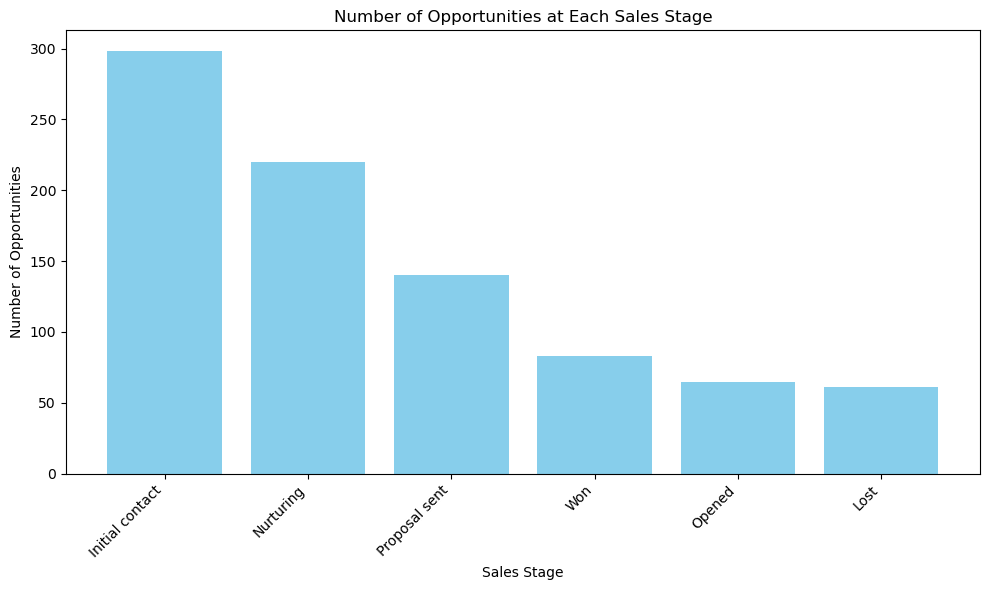

Note: 2133 opportunities have a missing (NaN) sales stage.


In [55]:
# Exclude NaN from the bar chart
stage_counts_no_nan = stage_counts[stage_counts['Stage'].notna()]

# Plot the bar chart without NaN
plt.figure(figsize=(10, 6))
plt.bar(stage_counts_no_nan['Stage'].astype(str), stage_counts_no_nan['Opportunity_Count'], color='skyblue')
plt.xlabel('Sales Stage')
plt.ylabel('Number of Opportunities')
plt.title('Number of Opportunities at Each Sales Stage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Indicate the number of NaN stages
nan_count = stage_counts.loc[stage_counts['Stage'].isna(), 'Opportunity_Count'].sum()
if nan_count > 0:
    print(f"Note: {nan_count} opportunities have a missing (NaN) sales stage.")

**Monthly Sales Forecast**

This section forecasts expected sales revenue by month, using deal values weighted by their probability of closing. The results are presented in a formatted table and a bar chart, providing a clear view of projected sales trends over time.

,Month,Expected Sales ($)
0,2024-01,"$2,638.50"
1,2024-02,"$37,000.40"
2,2024-03,"$123,439.90"
3,2024-04,"$177,385.80"
4,2024-05,"$265,802.70"
5,2024-06,"$328,054.50"
6,2024-07,"$353,634.90"
7,2024-08,"$287,667.10"
8,2024-09,"$285,378.00"
9,2024-10,"$320,319.00"


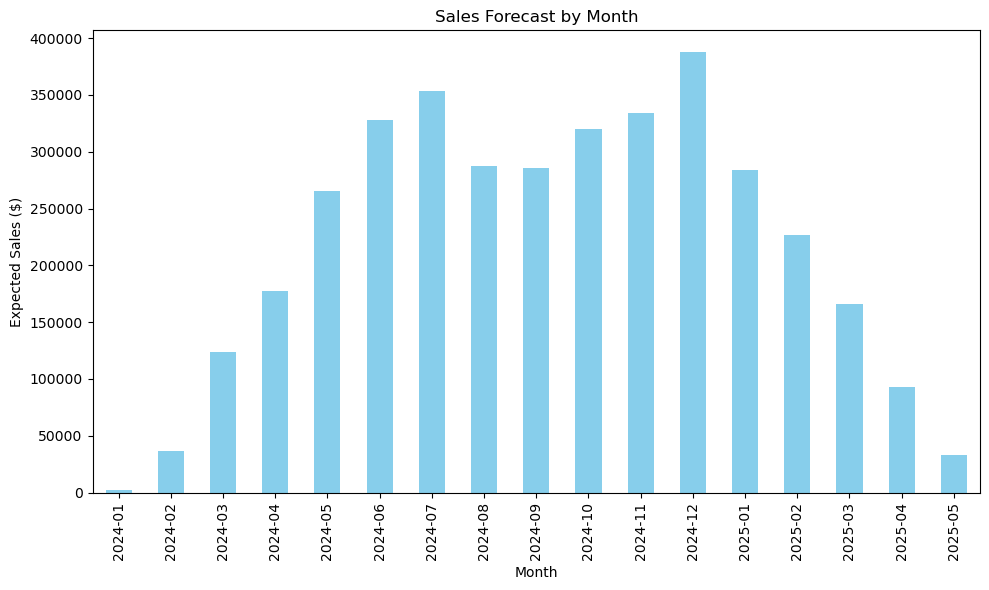

In [69]:
import matplotlib.pyplot as plt
from IPython.display import display

# Ensure date column is datetime
df_cleaned['Expected_close_date'] = pd.to_datetime(df_cleaned['Expected_close_date'], errors='coerce')

# Calculate expected value
df_cleaned['Expected_Value'] = df_cleaned['Deal_Value_USD'] * (df_cleaned['Probability_Pct'] / 100)

# Group by month
monthly_forecast = (
    df_cleaned
    .dropna(subset=['Expected_close_date'])
    .groupby(df_cleaned['Expected_close_date'].dt.to_period('M'))['Expected_Value']
    .sum()
    .sort_index()
)

# Create neat table
monthly_forecast_df = monthly_forecast.reset_index()
monthly_forecast_df['Expected_close_date'] = monthly_forecast_df['Expected_close_date'].astype(str)
monthly_forecast_df.columns = ['Month', 'Expected Sales ($)']

styled_table = (
    monthly_forecast_df
    .style
    .format({'Expected Sales ($)': '${:,.2f}'})
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center'), ('background-color', '#f2f2f2')]
    }])
)

display(styled_table)

# Plot the graph
plt.figure(figsize=(10,6))
monthly_forecast.plot(kind='bar', color='skyblue')
plt.title('Sales Forecast by Month')
plt.xlabel('Month')
plt.ylabel('Expected Sales ($)')
plt.tight_layout()
plt.show()

**Sales Cycle Duration by Country**

This section analyzes the average time taken to close sales opportunities across different countries. The summary table is sorted from highest to lowest by opportunity count, showing the number of opportunities, as well as the mean and median closure times (in days) for each country. This helps identify regions with the most sales activity and compare sales cycle efficiency.

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure date columns are datetime
df_cleaned['Lead_acquisition_date'] = pd.to_datetime(df_cleaned['Lead_acquisition_date'], errors='coerce')
df_cleaned['Actual_close_date'] = pd.to_datetime(df_cleaned['Actual_close_date'], errors='coerce')

# Calculate closure time in days
df_cleaned['Closure_Time_Days'] = (df_cleaned['Actual_close_date'] - df_cleaned['Lead_acquisition_date']).dt.days

# Drop rows with missing closure time
closure_df = df_cleaned.dropna(subset=['Closure_Time_Days', 'Country'])

# Show summary table by country
closure_summary = (
    closure_df.groupby('Country')['Closure_Time_Days']
    .agg(['count', 'mean', 'median'])
    .reset_index()
)
closure_summary.columns = ['Country', 'Opportunity Count', 'Mean Closure Time (days)', 'Median Closure Time (days)']

# Sort by Opportunity Count, descending
closure_summary = closure_summary.sort_values('Opportunity Count', ascending=False)

# Style and display the table without index
styled_closure = (
    closure_summary
    .style
    .format({'Mean Closure Time (days)': '{:.1f}', 'Median Closure Time (days)': '{:.1f}'})
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center'), ('background-color', '#f2f2f2')]
    }])
    .hide(axis='index')  # Hide the index
)
from IPython.display import display
display(styled_closure)

Country,Opportunity Count,Mean Closure Time (days),Median Closure Time (days)
Italy,80,65.5,64.0
Portugal,51,65.8,69.0
France,42,64.0,60.5
Germany,40,56.2,54.5
Switzerland,38,68.2,78.5
Netherlands,27,58.7,51.0
Belgium,25,58.6,61.0
Spain,25,59.6,58.0
Austria,20,66.0,70.5


**Win Rate by Country**

This section calculates and displays the sales win rate for each country. The summary table shows the total number of opportunities, number of wins, and the win rate (as a percentage), sorted from highest to lowest win rate. This provides insight into which regions have the most successful sales performance.

In [58]:
import pandas as pd
from IPython.display import display

# Filter for rows where Status is not null and Country is not null
df_valid = df_cleaned.dropna(subset=['Status', 'Country'])

# Calculate win rate: Status == 'Customer'
win_summary = (
    df_valid.groupby('Country')
    .agg(
        Total_Opportunities=('Status', 'count'),
        Wins=('Status', lambda x: (x == 'Customer').sum())
    )
    .assign(Win_Rate=lambda x: x['Wins'] / x['Total_Opportunities'])
    .sort_values('Win_Rate', ascending=False)
    .reset_index()
)

# Style the table
styled_win_table = (
    win_summary
    .style
    .format({'Win_Rate': '{:.2%}'})
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center'), ('background-color', '#f2f2f2')]
    }])
)

display(styled_win_table)

,Country,Total_Opportunities,Wins,Win_Rate
0,Netherlands,180,14,7.78%
1,Belgium,207,16,7.73%
2,Portugal,371,28,7.55%
3,Italy,620,37,5.97%
4,France,422,24,5.69%
5,Austria,199,11,5.53%
6,Spain,189,9,4.76%
7,Germany,420,17,4.05%
8,Switzerland,392,15,3.83%


**Top Product-Region Win Rates**

This section highlights the top 10 product and country combinations with the highest sales win rates. The results are shown in a formatted table and a horizontal bar chart, providing a clear view of which product-region pairs are most successful in converting opportunities into wins.

Country,Product,Total Opportunities,Wins,Win Rate
Belgium,Services,79,8,10.13%
Netherlands,Services,70,7,10.00%
Portugal,SAAS,158,15,9.49%
Belgium,SAAS,89,7,7.87%
Netherlands,Custom solution,41,3,7.32%
France,Custom solution,72,5,6.94%
Italy,SAAS,281,19,6.76%
Austria,Services,74,5,6.76%
Germany,Custom solution,78,5,6.41%
Portugal,Custom solution,64,4,6.25%


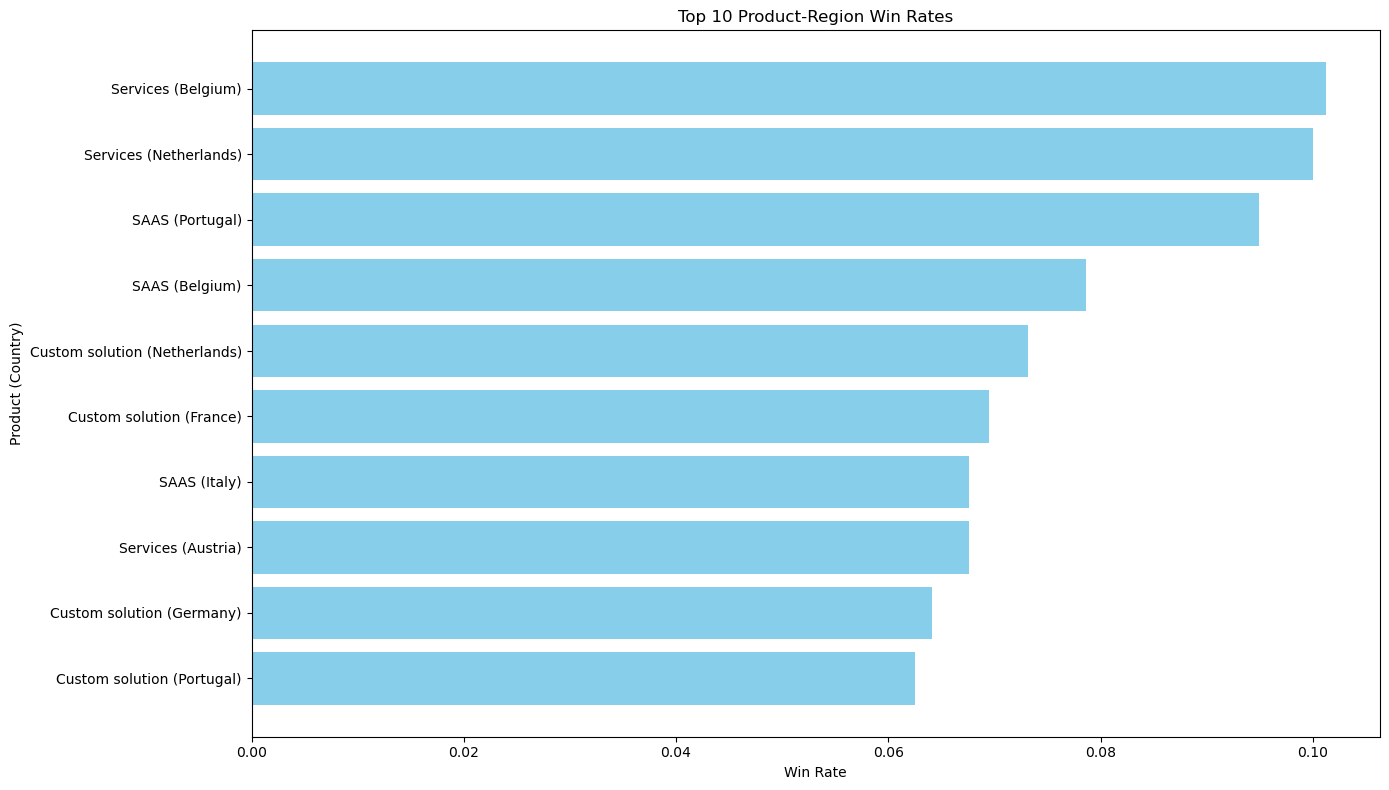

In [68]:
from IPython.display import display

# Replace 'Product' with the actual product column name if different
df_valid = df_cleaned.dropna(subset=['Status', 'Country', 'Product'])

win_by_product_region = (
    df_valid.groupby(['Product', 'Country'])
    .agg(
        Total_Opportunities=('Status', 'count'),
        Wins=('Status', lambda x: (x == 'Customer').sum())
    )
    .assign(Win_Rate=lambda x: x['Wins'] / x['Total_Opportunities'])
    .sort_values('Win_Rate', ascending=False)
    .reset_index()
)

# Remove underscores for display
win_by_product_region.columns = [col.replace('_', ' ') for col in win_by_product_region.columns]

# Move 'Country' column to the left
cols = win_by_product_region.columns.tolist()
cols.insert(0, cols.pop(cols.index('Country')))
win_by_product_region = win_by_product_region[cols]

# Show only the top 10 rows
win_by_product_region_top10 = win_by_product_region.head(10)

styled_win_table = (
    win_by_product_region_top10
    .style
    .format({'Win Rate': '{:.2%}'})
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center'), ('background-color', '#f2f2f2')]
    }])
)

display(styled_win_table.hide(axis='index'))  # Hide the index numbers


import matplotlib.pyplot as plt

# Calculate the maximum win rate in the top 10
max_win_rate = win_by_product_region_top10['Win Rate'].max()
xmax = max_win_rate * 1.05  # Add 5% margin for aesthetics

plt.figure(figsize=(14, 8))
plt.barh(
    win_by_product_region_top10.apply(lambda x: f"{x['Product']} ({x['Country']})", axis=1),
    win_by_product_region_top10['Win Rate'],
    color='skyblue'
)
plt.xlabel('Win Rate')
plt.ylabel('Product (Country)')
plt.title('Top 10 Product-Region Win Rates')
plt.xlim(0, xmax)
plt.tight_layout()
plt.gca().invert_yaxis()  # Highest win rate at the top
plt.show()